# Classification    

## Perceptron    
Assume that we have $n$ inputs, which we denote by $x_1,x_2,\dots,x_n$, and assume that each $x_i$ is a vector in $p$ dimensions, so that $x_i = [x_{i1}, \dots,x_{ip}]^T$, in other words, we have $p$ features - another way of writing this is: $x_i \in \mathbb{R}^p$ We will always assume that the first feature is a dummy feature, that is $x_{i1} = 1$, to account for the bias term.

Next, we let $w \in \mathbb{R}^p$ be the weight vector for our perceptron model. Note that the dimension of weight vector and the input vector need to be the same. This allows us to compute the dot product:

$$
h_w(x_i) =\langle w, x_i\rangle = \sum_{j=1}^p w_j x_{ij}.
$$

This is known as the activation. Note that the bias (intercept term) here is hidden in $w$. We could have equivalently defined our weight vector by $\tilde{w} \in \mathbb{R}^{p-1}$ and our bias term, $b\in \mathbb{R}$, and written 
$$
h_{\tilde{w},b}(x_i) = b +\sum_{j=2}^p w_j x_{ij},
$$
in other words, $w = (b,\tilde{w})^T$. It doesn't matter which setting you use, they are equivalent, and we will stick with the first one for the remainder.

The perceptron computes the dot product, and then outputs the sign of this value. 
The sign (denoted sign(x) usually, also in NumPy as `np.sign()`) function is defined by 
$$
\text{sign}(x) = \begin{cases}
+1 \quad &\text{if} \quad x>0\\
0 \quad &\text{if} \quad x=0\\
-1 \quad &\text{if} \quad x<0.
\end{cases}

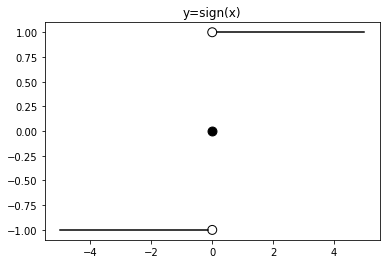

In [22]:
# Visualize np.sign()
import matplotlib.pyplot as plt
import numpy as np

xx_neg = np.linspace(-5,-0.15,1000)
xx_pos = np.linspace(0.15,5,1000)
plt.plot(xx_neg, np.sign(xx_neg), color='black')
plt.plot(xx_pos, np.sign(xx_pos), color='black')
plt.scatter(0,0, s=80, color='black')
plt.scatter(0,1, s=80, facecolors='none', edgecolors='black')
plt.scatter(0,-1, s=80, facecolors='none', edgecolors='black')
plt.title("y=sign(x)")
plt.show()

In a binary classification problem, we only have two classes, and so we will usually treat $\text{sgn}(0)=-1$, as in, anything with positive value is classified as $+1$, and anything with non-positive value is classified as $-1$. In other words, we will think of the sign function as looking like:

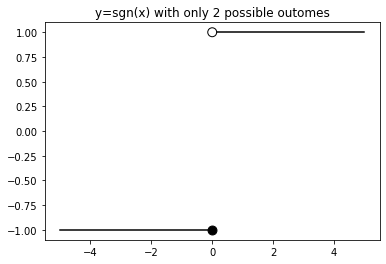

In [23]:
plt.plot(xx_neg, np.sign(xx_neg), color='black')
plt.plot(xx_pos, np.sign(xx_pos), color='black')
plt.scatter(0,-1, s=80, color='black')
plt.scatter(0,1, s=80, facecolors='none', edgecolors='black')
plt.title("y=sgn(x) with only 2 possible outomes")
plt.show()

Now, denote the output of the perceptron on input $x_i$ to be $o(x_i) = \text{sign}(h_w(x_i))$. The idea is to tweak the weight vector $w$ so that $h_w(x_i)$ is positive when $x_i$ has corresponding label $y_i=+1$, and $h_w(x_i)\le 0$ whenever $y_i = -1$.

### Perceptron Learning     

Perceptron Learning Algorithm:

\begin{align*}
&\text{input: } (x_1,y_1),\dots, (x_n, y_n)\\
&\text{initialise: } w^{(0)} = (0,0,\dots, 0) \in \mathbb{R}^p\\
&\text{for } t=1,\dots, \texttt{max\_iter}\\
&\qquad \text{if there is an index $i$ such that } y_i \langle w^{(t)}, x_i \rangle \le 0:\\
&\qquad \qquad   w^{(t+1)} = w^{(t)} + y_i x_i\\
&\qquad     \text{else:}\\
&\qquad \qquad \text{ output } w^{(t)}, t\\
\end{align*}
The perceptron is known as a mistake driven algorithm, since it updates $w$ only when a mistake is made (i.e. when $y_i \langle w, x_i \rangle \le 0$). 
It is also important to note that the perceptron only converges when it makes no mistakes on the data, so in other words, this algorithm can only terminate if the data set is linearly separable. 

We can implement the above in code and try to visualize the learning process:

In [24]:
class Perceptron:
    def __init__(self, w_init=None, lr=1):
        """
        Init model
        :param w_init: initial weights, if not provided, then all 0
        :param lr: learning rate, default 1
        """
        self.w = w_init if w_init is not None else np.zeros(X.shape[0])
        self.lr = lr

    def _plot(self, ax, X, y):
        # Only work with 2D data and binary classes
        w = self.w
        pos_points = X[np.where(y == 1)[0]]
        neg_points = X[np.where(y == -1)[0]]
        ax.scatter(pos_points[:, 1], pos_points[:, 2], color='blue')
        ax.scatter(neg_points[:, 1], neg_points[:, 2], color='red')
        xx = np.linspace(-6, 6)
        yy = -w[0] / w[2] - w[1] / w[2] * xx
        ax.plot(xx, yy, color='orange')

        ratio = (w[2] / w[1] + w[1] / w[2])
        xpt = (-1 * w[0] / w[2]) * 1 / ratio
        ypt = (-1 * w[0] / w[1]) * 1 / ratio
        
        ax.arrow(xpt, ypt, w[1], w[2], head_width=0.2, color='orange')
        ax.axis('equal')

    def fit(self, X, y, verbose=False, stop_step=1000, enable_converge_check=False):
        """
        Learn a perceptron algo
        :param X: Features
        :param y: Labels
        :param verbose: Print out the training process?
        :param stop_step: Stop at which step? (In case it can't converge)
        :param enable_converge_check: check if the given data can converge. Enabling this option will end up using more memory.
        :return: perceptron model
        """
        converge = False
        step = 0
        weights_set = set(tuple(self.w))
        epoch_cnt = 0
        while not converge:
            epoch_cnt += 1
            converge = True
            for i in range(X.shape[0]):
                step += 1
                if y[i] * (X[i].T @ self.w) <= 0:  # if mis-classification
                    self.w = self.w + self.lr * y[i] * X[i]
                    converge = False
                    if enable_converge_check:
                        w_tuple = tuple(self.w)
                        if w_tuple in weights_set:
                            print(f"[WARNING] Perceptron: Not a trainable dataset!")
                            return self
                        weights_set.add(w_tuple)
                if verbose:
                    print(f"Step {step:<4} weights = {self.w}")
                if step == stop_step:
                    print(f"Stops at step {step}, not converge.")
                    return self
            if verbose and X.shape[1] == 3:
                _, ax = plt.subplots()
                self._plot(ax, X, y)
                ax.set_title(f"Epoch {epoch_cnt}")
                plt.show()
        return self

    def predict(self, X, verbose: False):
        """
        Make prediction on data X
        :param X: input data
        :param verbose: print out values?
        :return: prediction
        """
        value = X.T @ self.w
        pred = np.sign(value)
        if verbose:
            print(f"{value=}, class: {pred}")
        return pred

##### Simple Example     
| x1 	 | x2 	 | y  	 |
|------|------|------|
| -2 	 | -1 	 | -1 	 |
| 2  	 | -1 	 | 1  	 |
| 1  	 | 1  	 | 1  	 |
| -1 	 | -1 	 | -1 	 |
| 3  	 | 2  	 | 1  	 |

Apply the Perceptron Learning Algorithm with starting values $w_0 = -3, w_1 = 0, w_2 = 8$, and
a learning rate 0.4.

Step 1    weights = [-3  0  8]
Step 2    weights = [-2.6  0.8  7.6]
Step 3    weights = [-2.6  0.8  7.6]
Step 4    weights = [-2.6  0.8  7.6]
Step 5    weights = [-2.6  0.8  7.6]


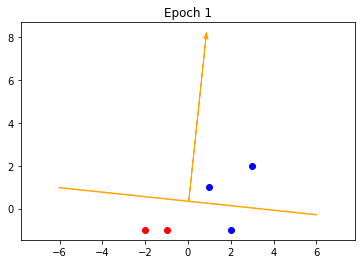

Step 6    weights = [-2.6  0.8  7.6]
Step 7    weights = [-2.2  1.6  7.2]
Step 8    weights = [-2.2  1.6  7.2]
Step 9    weights = [-2.2  1.6  7.2]
Step 10   weights = [-2.2  1.6  7.2]


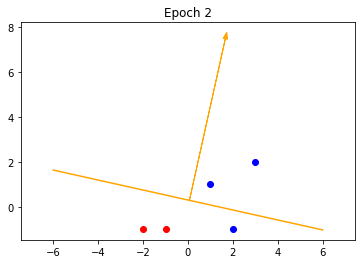

Step 11   weights = [-2.2  1.6  7.2]
Step 12   weights = [-1.8  2.4  6.8]
Step 13   weights = [-1.8  2.4  6.8]
Step 14   weights = [-1.8  2.4  6.8]
Step 15   weights = [-1.8  2.4  6.8]


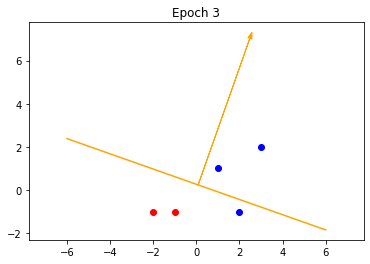

Step 16   weights = [-1.8  2.4  6.8]
Step 17   weights = [-1.4  3.2  6.4]
Step 18   weights = [-1.4  3.2  6.4]
Step 19   weights = [-1.4  3.2  6.4]
Step 20   weights = [-1.4  3.2  6.4]


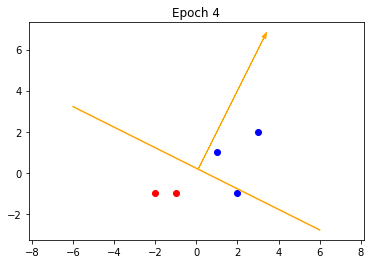

Step 21   weights = [-1.4  3.2  6.4]
Step 22   weights = [-1.  4.  6.]
Step 23   weights = [-1.  4.  6.]
Step 24   weights = [-1.  4.  6.]
Step 25   weights = [-1.  4.  6.]


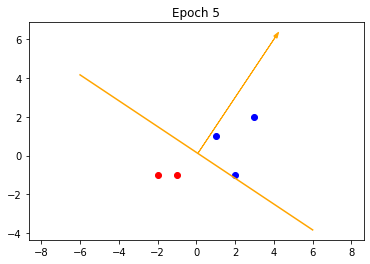

Step 26   weights = [-1.  4.  6.]
Step 27   weights = [-1.  4.  6.]
Step 28   weights = [-1.  4.  6.]
Step 29   weights = [-1.  4.  6.]
Step 30   weights = [-1.  4.  6.]


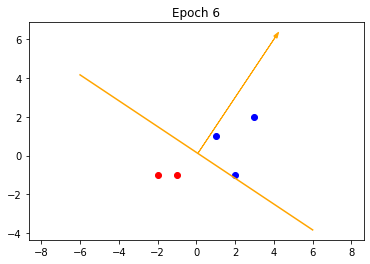

array([-1.,  4.,  6.])

In [25]:
X = np.array([
    [1, -2, -1],
    [1, 2, -1],
    [1, 1, 1],
    [1, -1, -1],
    [1, 3, 2]
])
y = np.array([-1, 1, 1, -1, 1])
w = np.array([-3, 0, 8])
model = Perceptron(w, 0.4).fit(X, y, True)
model.w

## Logistic Regression     
The logistic regression is defined as the problem of minimizing the cross entropy loss as the following:   
\begin{align*}
\hat{\beta}, \hat{\beta}_0 &= \arg \min_{\beta, \beta_0}  \mathcal{L}(\beta, \beta_0)\\
&= \arg \min_{\beta, \beta_0 \in \mathbb{R}^p} 
-\left [ 
     \sum_{i=1}^n y_i \ln \left (\frac{1}{1+e^{-\beta^T x_i - \beta_0}} \right) + (1-y_i) \ln \left (1-\frac{1}{1+e^{-\beta^T x_i - \beta_0}} \right)
\right]
\end{align*}

where $y_i \in \{0,1\}$ is binary valued and represents the label associated with the input $x_i$. In pratice however, we usually work with the following regularized version:

\begin{align*}
\hat{\beta}, \hat{\beta}_0 &= \arg \min_{\beta, \beta_0}  C\mathcal{L}(\beta, \beta_0) + \text{Penalty}(\beta),
\end{align*}

where Penalty $(\beta)$ is a penalty/regularization term applied to the weight vector $w$. For example, $\text{Penalty}(\beta) = \|\beta\|_1$ when we want to apply $\ell_1$ regularization to $w$ (this would be the logistic version of the LASSO). Note that we not usually penalize the intercept/bias term $w_0$. Note also the introduction of the hyperparameter $C$, which does a similar job to $\lambda$ in the lasso/ridge regression model formulations.

#### Understanding Logistic Regression     
Given a dataset $D=\{(x_i,y_i)\}_{i=1}^n$, where $x_i$'s represent the feature vectors, just as in linear regression, but $y_i$'s are now binary.
The goal is to model the output as a probability that a particular data point belongs to one of two classes.
Denote this predicted probability by
$$
P(y=1|x)=p(x)
$$
and model it as
$$
\hat{p}=\sigma(\hat{w}^Tx), \quad \sigma(z)=\frac{1}{1+e^{-z}}
$$
where $\hat{w}$ is the estimated weight vector.
Then construct a classifier by assigning the class that has the highest probability:
$$
\hat{y} = \arg\max_{k=0,1}P(\hat{y}=k|x)= 
\begin{cases}
1 \quad if\ \sigma(\hat{w}^Tx) \ge 0.5 \\
0 \quad otherwise
\end{cases}
$$

The role of the logistic sigmoid function $\sigma()$ is to make sure that the output is in $[0,1]$, as $w^Tx \in (-\infty,+\infty)$.

##### Statistical view of logistic regression     
Assume the following binary valued random variable:
$$
y|x ~ Bernoulli(p^*), \quad\quad p^*=\sigma(x^Tw^*)
$$
where $p^*=\sigma(x^Tw^*)$ is the true unknown probability of a response belonging to class 1. 
Assume this is controlled by some true weight vector $w^*$.
The assumption implies that
$$
P(y=1|x)=p^y(1-y)^{1-y}
$$
Then the log-likelihood is like:
\begin{align*}
\ln L(w)&=\ln P(y_1,...,y_n|x_1,...,x_n) \\
&= \ln \left \{\prod_{i=1}^nP(y_i|x_i) \right \} \\
&=\sum_{i=1}^{n}\ln P(y_i|x_i)  \\
&=\sum_{i=1}^{n}\ln (p_i^{y_i}(1-p_i)^{1-y_i})  \\
&=\sum_{i=1}^{n}[y_i\ln p_i + (1-y_i)ln(1-p_i)]  \\
\end{align*}
We know that
$$
p_i = \sigma(w^Tx_i) = \frac{1}{1+e^{-w^Tx_i}},
$$
and so
\begin{align*}
\ln L(w)&=\sum_{i=1}^{n}[y_i\ln \sigma(w^Tx_i) + (1-y_i)ln(1-\sigma(w^Tx_i))]  \\
&=\sum_{i=1}^{n}\left [y_i\ln\left(\frac{\sigma(w^Tx_i)}{1-\sigma(w^Tx_i)}\right) + \ln(1-\sigma(w^Tx_i)) \right ]
\end{align*}
The optimization problem is then
$$
\hat{w}_{MLE}=\arg\max_{w\in \mathbb{R}^p}\ln L(w)
$$

##### Optimization perspective of logistic regression     
The MSE objective is simply
$$
\arg\min_w\frac{1}{n}\|y-\sigma(Xw)\|_2^2 \quad \equiv \quad \arg\min_w\frac{1}{n}\sum_{i=1}{n}(y_i-\sigma(w^Tx_i))^2
$$
where $y=[y_1,...,y_n]^T$ and $\sigma(Xw)$ is the element-wise application of $\sigma$ to the vector $Xw$.

This objective makes sense mathematically, but the squared error does not seem like a 
particularly good way to measure the distance between $y_i$ and our prediction $\sigma(w^Tx_i)$.
The reason being that $y_i$ is binary, whereas our prediction is real-valued. 
There are more technical reasons for not wanting to use the MSE, 
in particular the MSE is not convex in the parameter vector $w$ for this problem, and this makes it harder to optimize.

Quantifying how far it is from one discrete probability distribution(P) to another(Q) is a very common task in statistics and information theory.
The most common way to measure the discrepancy between the two is to compute the Kullback-Liebler (KL) divergence, also known as relative entropy, which is defined by:
$$
D_{KL}(P\|Q)=\sum_{x\in \chi}P(x)\ln\frac{P(x)}{Q(x)}
$$
One way to think of this is that P is the true distribution, and Q is the estimated one, and we are trying to figure out how bad the estimate is. Let's say P and Q are Bernoulli random variables which can take on only two values (0, 1), then we have: 
\begin{align*}
D_{KL}(P\|Q)&=\sum_{x=0}^1P(x)\ln\frac{P(x)}{Q(x)} \\
&= P(X=0)\ln\frac{P(X=0)}{Q(X=0)} + P(X=1)\ln\frac{P(X=1)}{Q(X=1)} \\
&= (1-p)\ln\frac{1-p}{1-q} + p\ln\frac{p}{q}
\end{align*}

So we can use this method to quantify the prediction $\hat{p}_i$ and the true label $y_i$ that $P_i=Bernoulli(y_i)$ and $Q_i=Bernoulli(\hat{p}_i)$. 
\begin{align*}
\mathcal{L}_{KL}(w)&=\sum_{i=1}^{n}D_{KL}(Bernoulli(y_i) \| Bernoulli(\hat{p}_i)) \\
&=\sum_{i=1}^{n}(1-y_i)\ln\frac{1-y_i}{1-\hat{p}_i} + y_i\ln\frac{y_i}{\hat{p}_i}
\end{align*}
Expand the individual terms as:
\begin{align*}
(1-y_i)\ln\frac{1-y_i}{1-\hat{p}_i} + y_i\ln\frac{y_i}{\hat{p}_i} &= (1-y_i)\ln(1-y_i)-(1-y_i)\ln(1-\hat{p}_i)+y_i\ln y_i - y_i\ln \hat{p}_i \\
&\propto^w -(1-y_i)\ln(1-\hat{p}_i)-y_i\ln\hat{p}_i
\end{align*}
Only the terms involve $\hat{p}_i$ are functions of $w$, so removing other terms won't affect the optimization (with respect to $w$) problem. Put it back:
\begin{align*}
\mathcal{L}_{KL}(w)&\propto^w -\sum_{i=1}^n[(1-y_i)\ln(1-\hat{p}_i)+y_i\ln\hat{p}_i] \\
&= -\sum_{i=1}^n\left [y_i\ln(\frac{\hat{p}_i}{1-\hat{p}_i})+\ln(1-\hat{p}_i)\right ] \\
&= -\sum_{i=1}^n\left [y_i\ln\left (\frac{\sigma(w^Tx_i)}{1-\sigma(w^Tx_i)} \right )+\ln(1-\sigma(w^Tx_i))\right ] \\
\end{align*}

In logistic regression, cross-entropy loss is used, defined by
$$
\mathcal{L}_{XE}(a, b) = -a\ln\frac{a}{b} - (1-a)\ln\frac{1-a}{1-b}
$$
We can see that minimizing the cross entropy loss is equivalent to minimizing the KL loss.
$$
\mathcal{L}_{KL}(w)\propto^w \mathcal{L}_{XE}(w)
$$
therefore,
$$
\arg\min_w\mathcal{L}_{KL}(w) = \arg\min_w\mathcal{L}_{XE}(w)
$$
From the statistics view of logistic regression we know that:
\begin{align*}
\hat{w}_{MLE}&=\arg\max_{w\in \mathbb{R}^p}\ln L(w) \\
&=\arg\max_{w\in \mathbb{R}^p}\sum_{i=1}^n \left [y_i\ln\left (\frac{\sigma(w^Tx_i)}{1-\sigma(w^Tx_i)} \right )+\ln(1-\sigma(w^Tx_i))  \right ] \\ 
&=\arg\min_{w\in \mathbb{R}^p}-\sum_{i=1}^n \left [y_i\ln\left (\frac{\sigma(w^Tx_i)}{1-\sigma(w^Tx_i)} \right )+\ln(1-\sigma(w^Tx_i))  \right ] \\
&= \arg\min_{w\in \mathbb{R}^p}  \mathcal{L}_{KL}(w)\\
&= \arg\min_{w\in \mathbb{R}^p}\mathcal{L}_{XE}(w) 
\end{align*}

**Conclusion**: minimizing the XE loss is equivalent to maximizing the log-likelihood.

The above optimization problem can be solved with gradient decent as it has no closed form solution. Taking the second derivative (Hessian) of XE loss we can find that it is always greater or equal to 0. So it is guaranteed to converge to a global minimum. 

#### Logistic Regression with sklearn
In `sklearn` <a href ="https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression">logistic regression implementation (Section 1.1.11)</a> which claims to minimize the following objective:

\begin{align*}
    \hat{w}, \hat{c} =\arg \min_{w, c} \left[\|w\|_1 + C \sum_{i=1}^n \log (1+ \exp (-\tilde{y}_i(w^T x_i + c))) \right ].
\end{align*}
        
It turns out that this objective is identical to our objective above ($\hat{\beta}_0 = \hat{c}$ and $\hat{\beta} = \hat{w}$), but only after re-coding the variables to be in $\{-1,1\}$ instead of binary values $\{ 0,1\}$. That is, $\tilde{y}_i \in \{-1,1\}$, whereas $y_i \in \{0,1 \}$. 

    
We can focus on a single $i$ for simplicity:
\begin{align*}
    &y_i \ln (1+\exp(-\beta^T x_i - \beta_0))+ (1-y_i) 
    \ln \left ( 1+\exp(\beta^T x_i + \beta_0) \right)\\
    &= \begin{cases}
        \ln \left ( 1+\exp(-1 \times (\beta^T x_i + \beta_0)) \right) \qquad &\text{if} \quad y=1\\
        \ln \left ( 1+\exp(1 \times (\beta^T x_i + \beta_0)) \right) \qquad &\text{if} \quad y=0
    \end{cases}\\
    &= \begin{cases}
        \ln \left ( 1+\exp(-\tilde{y}_i \times (\beta^T x_i + \beta_0)) \right) \qquad &\text{if} \quad \tilde{y}_i=1\\
        \ln \left ( 1+\exp(-\tilde{y} \times (\beta^T x_i + \beta_0)) \right) \qquad &\text{if} \quad \tilde{y}=-1
    \end{cases}\\
    &= \ln \left ( 1+\exp(-\tilde{y}(\beta^T x_i + \beta_0)) \right).
\end{align*}
        $C$ attaches higher importance to the `fit'term, so as $C$ increases, we care more about fitting than the penalty, and so $C$ plays an inverse role to that of $\lambda$ in standard LASSO, i.e. $C \propto 1/\lambda$. This is a standard trick used to rewrite loss functions.

##### Try Logistic regression on MNIST Dataset     
Load MNIST dataset with `torchvision`:

In [27]:
from torchvision import transforms
from torchvision.datasets import MNIST

# Load dataset (download if necessary)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trainset = MNIST(root = './data', train=True, download=True, transform=transform)
testset = MNIST(root = './data', train=False, download=True, transform=transform)

Number of observations in train set: 60000
Number of observations in test  set: 10000


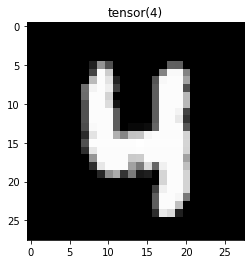

In [29]:
# Take a look at the dataset

# size of datasets
print(f"Number of observations in train set: {trainset.data.shape[0]}")
print(f"Number of observations in test  set: {testset.data.shape[0]}")

# plotting an image in the dataset using imshow()
idx = 8964
plt.imshow(trainset.data[idx], cmap='gray')
plt.title(trainset.targets[idx])
plt.show()

There are 10 classes (0-9) in the MNIST dataset, but only 2 are needed for this example of Logistic Regression. 
Logistic Regression also expects a vector of input, so a $28\times 28$ image will be flattened as a 784 dimensional vector. 

We will take our train set to be 60\% of the available images, whereas the validation and test sets will be 20\% each. We will also convert the tensor datasets to NumPy arrays.

To make the problem more challenging for the model, we will work with a smaller sample of size `nSample`, and we will also randomly choose a subset of $s$ features and omit the rest.

In [45]:
from sklearn.model_selection import train_test_split

# sample size and features to work with
s = 40                                                                    # reduced features to work with 
sFeatures = np.random.choice(np.arange(784), size=s, replace=False)       # choose s features randomly from the 784
sFeatures.sort()
nSample = 100


# choose two class labels
class1Label = 0
class2Label = 1

class1Images = trainset.data[trainset.targets==class1Label].reshape(-1,784).numpy()      # images with class1
class2Images = trainset.data[trainset.targets==class2Label].reshape(-1,784).numpy()      # images with class2

# work with a smaller sample size
class1Images = class1Images[:nSample, sFeatures]
class2Images = class2Images[:nSample, sFeatures]
X = np.concatenate((class1Images, class2Images), axis=0)
y = np.concatenate((np.zeros(class1Images.shape[0]), np.ones(class2Images.shape[0])))

# create Xtrain, Xvalid, Xtest
Xtrain, X_, ytrain, y_ = train_test_split(X, y, test_size=0.4, shuffle=True)
Xvalid, Xtest, yvalid, ytest = train_test_split(X_, y_, test_size=0.5, shuffle=True)

print(f'Xtrain shape = {Xtrain.shape}')
print(f'Xvalid shape = {Xvalid.shape}')
print(f'Xtest  shape = {Xtest.shape}')

Xtrain shape = (120, 40)
Xvalid shape = (40, 40)
Xtest  shape = (40, 40)


In order to choose the correct value of the hyperparameter $C$, we will use K-fold cross validation. As always, we use the validation set to do any form of hyperparameter tuning.
    
Create a grid of 100 $C$ values ranging from $C=0.0001$ to $C=1$ in equally sized increments. Use the  <a href ="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">`sklearn.model_selection.GridSearchCV` </a> to do the grid search cross validation using your parameter grid. For the `estimator` argument, use the `sklearn.linear_model.LogisticRegression` model with `l1` penalty and `liblinear` solver and find the optimal value of $C$ when performing 10-fold cross validation using `neg_log_loss` scoring.

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

C_grid = np.linspace(0.0001, 0.2, 100)
grid_lr = GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='liblinear'),
                       cv=10, 
                       param_grid={'C': C_grid}, 
                       scoring='neg_log_loss')
grid_lr.fit(Xvalid, yvalid)
Cbest = grid_lr.best_params_['C']
print(f'Best C according to gridsearch: {Cbest}')

logistic_mod = LogisticRegression(penalty='l1',  solver='liblinear', C=Cbest).fit(Xtrain, ytrain)
print(f'Train Accuracy: {accuracy_score(logistic_mod.predict(Xtrain), ytrain)}')
print(f'Test Accuracy: {accuracy_score(logistic_mod.predict(Xtest), ytest)}')

Best C according to gridsearch: 0.19798080808080806
Train Accuracy: 1.0
Test Accuracy: 0.925


#### predict_proba vs. predict
Many classification models in `sklearn` (not just logistic regression) have two methods that can be somewhat confusing, so let's make sure we understand what each of these methods does and when to use each one. 
In what follows, let's assume we called our logistic model `logistic_mod`. Then, recall that a logistic regression is a type of regression, meaning it outputs a *probability* that an input belongs to a particular class (the class coded as $y=1$). 
In order to turn this into a classifier, we use a threshold value $t$ (known as the discrimination threshold) and classify any probability that is $t$ or greater as belonging to class $y=1$, and $y=0$ otherwise. 
The choice of $t$ is up to the modeler, and the default value is $t=0.5$. 

With this in mind, the `predict_proba()` method returns the predicted probability that the model returns for a particular input, whereas `predict()` returns the predicted class. 
If we are solely interested in model accuracy, then two different models that have the same predicted labels will be of equal value to us. However, the accuracy can be a crude way of comparing models. 

For example, consider two models: m1 and m2. Let's say we have inputs `[x1,x2,x3,x4]` with labels $[1, 0, 0, 0]$ and the following holds:

```
m1.predict([x1,x2,x3,x4]) = [1,0,0,0]
m2.predict([x1,x2,x3,x4]) = [1,0,0,0]
```

So both models have 100\% accuracy. However, let's say we also get:

```
m1.predict_proba([x1,x2,x3,x4]) = [[0.1, 0.9],
                                   [0.99, 0.01]
                                   [0.9, 0.1],
                                   [0.92, 0.08]]
m2.predict_proba([x1,x2,x3,x4]) = [[0.49, 0.51] ,
                                   [0.51, 0.49],
                                   [0.52, 0.48],
                                   [0.51, 0.49]]
```
The `predict_proba` method returns the predicted probability for each class, which is why there are two numbers for each `xi`.

Now, clearly m1 is able to discriminate the positive and negative classes much more effectively than m2, but the two models would be equivalent in terms of accuracy score. 
If we are more interested in the ability of a model to discriminate between two classes, we would consider different metrics, such as the cross entropy loss, which is also called the log-loss, and is implemented in `sklearn.metrics.log_loss`. 
The cross entropy measures **the distance between a predicted probability and the truth**, and is defined by

$$
\mathcal{L}(w) = -\sum_{i=1}^n (y_i \ln \hat{p}_i + (1-y_i) \ln(1-\hat{p}_i)).
$$

In our toy example,

```
ll_m1 = log_loss([1,0,0,0], m1.predict_proba([x1,x2,x3,x4])) = 0.0760
ll_m2 = log_loss([1,0,0,0], m2.predict_proba([x1,x2,x3,x4])) = 0.6685
```

So the log-loss of m1 is much lower than that of m2, and we would prefer m1 if our criteria is log-loss and not accuracy.

#### The Trade-Off between TPR (Sensitivity) and TNR (Specificity)
A binary classifier can have one of four possible outcomes:
1. True Positive (TP): classifier predicts $\hat{y}=1$ when true label is $y=1$
2. False Positive (FN): classifier predicts $\hat{y}=1$ when true label is $y=0$
3. True Negative (TN): classifier predicts $\hat{y}=0$ when true label is $y=0$
4. False Negative (FN): classifier predicts $\hat{y}=0$ when true label is $y=1$

True positives and True negatives are clearly good, whereas false positives and false negatives are obviously not so good. 

Two examples:

Example 1 (CANCER DETECTION): You build a classifier that looks at the output of some costly medical test and attempts to predict whether patient has a rare form of cancer and needs further testing ($y=1$) or no cancer ($y=0$). The goal here is to save as many lives as possible. 
A false positive means that we perform further tests on someone who does not have cancer. A false negative means that we send a patient suffering from cancer home. Clearly a false negative is much more costly (in terms of saving lives) than is a false positive.

Example 2 (MARKETING CAMPAIGN): You work for a bank and wish to identify new customers to send ads to about a new credit card. The classifier identifies a potential customer and sends them a targeted ad via email ($y=1$) or labels them as not a potential customer ($y=0$). The goal here is to increase the revenue stream of the bank.
In marketing, a false positive means we send someone who is not interested an email ad. Most likely they delete the email without much thought. A false negative means we miss the chance to gain a new customer that will grow our business. A false negative is arguably much worse in this scenario. 

We define the following terms, each of which (somewhat annoyingly) has many names in the literature:

- True Positive Rate (TPR), Sensitivity, Recall: $\text{TPR} = \frac{\text{TP}}{\text{P}} = \frac{\text{TP}}{\text{TP} + \text{FN}}$ where $P$ is the actual number of positive values in the data.
- True Negative Rate (TNR), Specificity, Selectivity: $\text{TNR} = \frac{\text{TN}}{\text{N}} = \frac{\text{TN}}{\text{TN} + \text{FP}}$ where $N$ is the actual number of negative values in the data.

The Receiver Operator Characteristic (ROC) curve is a graphical depiction of what happens to the TPR and FPR = 1-TNR as we vary the threshold $t$. It is a good way of comparing different classification models. Let's consider a couple of logistic regression models fit to the MNIST problem but with different $C$ values, and compare them by looking at their ROC curves. The Area Under the Curve (AUC) gives us a nice summary of how good a particular model is, it is the area under each of the ROC curves.

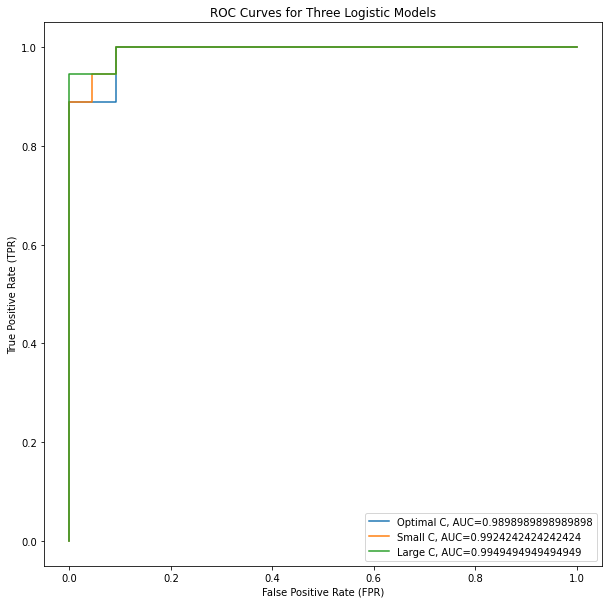

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score

# choosing C via cross validation then computing FPR and TPR at all thresholds
logistic_mod_1 = LogisticRegression(penalty='l1',  solver='liblinear', C=Cbest).fit(Xtrain, ytrain)
mod_1_preds = logistic_mod_1.predict_proba(Xtest)[:,1]        # note, predictions need to be just for one of the classes
fpr_1, tpr_1, _ = roc_curve(ytest, mod_1_preds)
auc_1 = roc_auc_score(ytest, mod_1_preds)

# choosing C small
logistic_mod_2 = LogisticRegression(penalty='l1', solver='liblinear', C=0.02).fit(Xtrain, ytrain)
mod_2_preds = logistic_mod_2.predict_proba(Xtest)[:,1]
fpr_2, tpr_2, _ = roc_curve(ytest, mod_2_preds)
auc_2 = roc_auc_score(ytest, mod_2_preds)

# choosing C to be very large (no regularization)
logistic_mod_3 = LogisticRegression(solver='liblinear', C=1000).fit(Xtrain, ytrain)
mod_3_preds = logistic_mod_3.predict_proba(Xtest)[:,1]
fpr_3, tpr_3, _ = roc_curve(ytest, mod_3_preds)
auc_3 = roc_auc_score(ytest, mod_3_preds)


fig = plt.figure(figsize=(10,10))
plt.plot(fpr_1, tpr_1, label="Optimal C, AUC="+str(auc_1))
plt.plot(fpr_2, tpr_2, label="Small C, AUC="+str(auc_2))
plt.plot(fpr_3, tpr_3, label="Large C, AUC="+str(auc_3))
plt.ylabel("True Positive Rate (TPR)")
plt.xlabel("False Positive Rate (FPR)")
plt.title("ROC Curves for Three Logistic Models")
plt.legend()
plt.show()

## Multi-class classification - Softmax Regression

In Softmax Regression, we allow the label to take on one of $K$ possible values, so given an input $x$, we would like to estimate $P(Y=k|x)$ for $k=1,\dots, K$. The model must therefore output a $K$ dimensional vector of probabilities whose elements sum to $1$, i.e. 

\begin{align*}
h(x) = 
\begin{bmatrix}
P(y=1|x) \\ P(y=2|x)\\ \vdots \\ P(y=K|x)
\end{bmatrix}
\end{align*}

#### Short motivation for softmax regression 
In the logistic regression problem (binary $y$), we wish to estimate a probability: $P(y=1|x)$. One approach is to use a linear model:

$$
P(y=1|x) = w^T x,
$$

where $w$ is a parameter vector that we estimate. The problem with this however is that a probability must be in the range $[0,1]$, whereas $w^T x \in (-\infty, \infty)$. A solution is to then wrap the linear model in a logistic sigmoid:

$$
P(y=1|x) = \sigma(w^T x) = \frac{1}{1+e^{-w^T x}},
$$

which guarantees that our estimated probability is actually a probability, regardless of the choice of $w$. Let's extend this idea to the multi-class case: assume that for each class we have a $p$-dimensional vector $\theta_1 \in \mathbb{R}^p, \theta_2 \in \mathbb{R}^p, \dots, \theta_K \in \mathbb{R}^p$, so we have a total of $Kp$ unkown parameters to be estimated, and we will stack these unkown vectors into a single matrix for brevity:

$$
\Theta = [\theta_1,\dots, \theta_K] \in \mathbb{R}^{p \times K}.
$$

Now, we want to estimate $K$ probabilities, so we could just do the linear model approach:

\begin{align*}
P(y=1|x) &= \theta_1^T x\\
P(y=2|x) &= \theta_2^T x\\
& \vdots\\
P(y=K|x) &= \theta_K^T x
\end{align*}

in which case we run into the same issue that each term is not guaranteed to be a probability. We can use the same trick of using the logistic sigmoid:

\begin{align*}
P(y=1|x) &= \sigma(\theta_1^T x)\\
P(y=2|x) &= \sigma(\theta_2^T x)\\
& \vdots\\
P(y=K|x) &= \sigma(\theta_K^T x).
\end{align*}

Which seemingly fixes the problem - but we are faced with another problem now, there is no guarantee that the sum of the probabilities add up to one. An easy fix is to normalize the probabilities by their sum:

\begin{align*}
P(y=1|x) &= \frac{\sigma(\theta_1^T x)}{\sum_{j=1}^k \sigma(\theta_j^T x)}\\
P(y=2|x) &= \frac{\sigma(\theta_2^T x)}{\sum_{j=1}^k \sigma(\theta_j^T x)}\\
& \vdots\\
P(y=K|x) &= \frac{\sigma(\theta_K^T x)}{\sum_{j=1}^k \sigma(\theta_j^T x)}.
\end{align*}

This ensures two things:
1. each element is a valid probability (it has to be between $0$ and $1$.
2. the sum of the estimated probabilities is 1.

Our softmax regression model therefore takes the form:

\begin{align*}
h_\Theta (x) = 
\begin{bmatrix}
P(y=1|x) \\ P(y=2|x)\\ \vdots \\ P(y=K|x)
\end{bmatrix}
=
\frac{1}{ \sum_{j=1}^k \sigma(\theta_j^T x)}
\begin{bmatrix}
\sigma(\theta_1^T x)\\
\sigma(\theta_2^T x)\\
\vdots \\
\sigma(\theta_K^T x)
\end{bmatrix}
\end{align*}

and we now have a parameter matrix $\Theta$ to estimate. What remains is to define the loss function we will use for the problem. Recall in the logistic case the loss function is:

\begin{align*}
\mathcal{L} (w)
&= -\sum_{i=1}^n (y_i \ln \hat{p}_i + (1-y_i) \ln(1-\hat{p}_i))\\
&= -\sum_{i=1}^n (y_i \ln P(y_i = 1|x_i) + (1-y_i) \ln P(y_i = 0|x_i),
\end{align*}

and noting that $y_i = 0$ or $y_i = 1$, we can rewrite this as 
\begin{align*}
\mathcal{L} (w)&= -\sum_{i=1}^n \sum_{j=0}^1 \mathbf{1}\{y_i = j \} \ln P(y_i = j|x_i),
\end{align*}

where $ \mathbf{1}\{y_i = j \}$ is an indicator variable, which simply takes the value $1$ if the term inside the brackets is true, and zero otherwise. For example $\mathbf{1}\{ 1+2=3\} = 1$. Now, the reason we wrote the loss this way is that it allows us to generalize to the softmax regression problem in the following way:

\begin{align*}
\mathcal{L}(\Theta) 
&= -\sum_{i=1}^n \sum_{j=0}^K \mathbf{1}\{y_i = j \} \ln P(y_i = j|x_i)\\
&= -\sum_{i=1}^n \sum_{j=0}^K \mathbf{1}\{y_i = j \} \ln \frac{\sigma(\theta^T_j x_i)}{\sum_{k=1}^K \sigma(\theta^T_k x_i)}.
\end{align*}

##### Softmax Regression in sklearn

In [48]:
# subsample the data to make it more manageable
nSample = 2000
idxsTrain = np.random.choice(np.arange(trainset.data.shape[0]), size=nSample, replace=False)
idxsTest = np.random.choice(np.arange(testset.data.shape[0]), size=nSample//5, replace=False)

Xtrain = trainset.data.reshape(-1, 784).numpy()[idxsTrain, :]
Xtest = testset.data.reshape(-1, 784).numpy()[idxsTest, :]            
ytrain = trainset.targets.numpy()[idxsTrain]
ytest = testset.targets.numpy()[idxsTest]

print(f'Xtrain shape = {Xtrain.shape}')
print(f'Xtest  shape = {Xtest.shape}')

Xtrain shape = (2000, 784)
Xtest  shape = (400, 784)


`sklearn` handles softmax regression easily using the same `LogisticRegression` object as used for the binary regression problem, with an added argument `multi_class` which controls whether we fit a binary logistic or a softmax regression (also referred to as multinomial logistic regression). If we set `multi_class=ovr`, it fits a single logistic to every single label (i.e. $K$ standard logistic fits), whereas if we set `multi_class=multinomial`, we will get a softmax regression fit. Note that the `multi_class=multinomial` is not compatible with the `solver=liblinear` setting.
    
Fit a multinomial regression to the entire MNIST dataset using the `sag` solver and `l2` regularization with `C=50` (may need to increase the `max_iter` to 1000 here), additionally we can increase the `tol` argument to `0.001` for faster convergence. 
Use the `sklearn.metrics.confusion_matrix`, produce a confusion matrix (on the test set) to display the results.

In [50]:
from sklearn.metrics import confusion_matrix

sm_mod = LogisticRegression(multi_class='multinomial',
                            penalty='l2',
                            C=50,
                            solver='sag',
                            tol=.001,
                            max_iter=1000
                            ).fit(Xtrain, ytrain)

ypred = sm_mod.predict(Xtest)
conf_m = confusion_matrix(ytest, ypred)
print("Confusion_matrix: \n"+str(conf_m))

Confusion_matrix: 
[[29  0  1  0  0  1  1  1  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 40  2  0  0  1  1  2  0]
 [ 0  0  0 34  0  1  0  0  3  0]
 [ 0  0  0  0 30  0  0  0  1  3]
 [ 1  0  0  2  0 27  1  0  2  1]
 [ 2  1  0  0  1  1 32  0  0  0]
 [ 0  0  2  1  0  0  0 39  0  2]
 [ 0  0  1  2  0  5  1  0 29  3]
 [ 0  1  0  1  3  1  0  2  0 35]]


Plot confusion matrix with `seaborn`

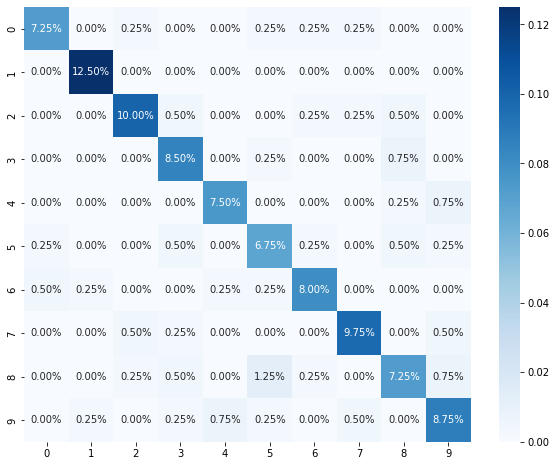

In [57]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(conf_m/np.sum(conf_m), annot=True, fmt='.2%', cmap='Blues')
plt.show()

Plot the estimated coefficient vector associated with each class.

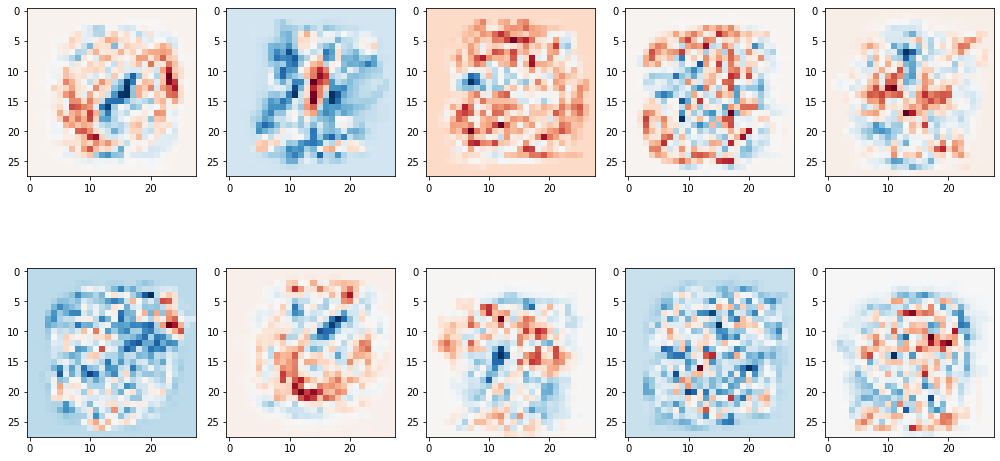

In [58]:
fig, axes = plt.subplots(2, 5, figsize=(14,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(sm_mod.coef_[i].reshape(28,28), cmap=plt.cm.RdBu_r, interpolation='nearest')
plt.tight_layout()
plt.show()